<a href="https://colab.research.google.com/github/szakmarynandor/FAKT-MLCourse/blob/main/stock_pred_hw06.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Stock price prediction

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

###Tesla részvény árfolyamának feltöltése

In [28]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
tesla=pd.read_csv('/content/drive/My Drive/FAKT_ML/tesla.csv')

In [30]:
tesla.shape

(1570, 8)

In [31]:
tesla.head()

,Unnamed: 0,TSLA.Open,TSLA.High,TSLA.Low,TSLA.Close,TSLA.Volume,TSLA.Adjusted,date
0,X2016.01.04,46.144001,46.276001,43.799999,44.681999,34135500.0,44.681999,2016-01-04
1,X2016.01.05,45.271999,45.377998,44.000000,44.686001,15934000.0,44.686001,2016-01-05
2,X2016.01.06,44.000000,44.009998,43.195999,43.807999,18895500.0,43.807999,2016-01-06
3,X2016.01.07,42.838001,43.688000,42.734001,43.130001,17771500.0,43.130001,2016-01-07
4,X2016.01.08,43.571999,44.088001,42.153999,42.200001,18140500.0,42.200001,2016-01-08


In [32]:
training_set = tesla[['TSLA.Close']]

In [33]:
training_set

,TSLA.Close
0,44.681999
1,44.686001
2,43.807999
3,43.130001
4,42.200001
...,...
1565,993.979980
1566,999.109985
1567,1013.919983
1568,1010.640015


###Normalizálás

In [34]:
#normalizer = StandardScaler()

In [35]:
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)

In [36]:
training_set_scaled

array([[0.01327699],
       [0.01328032],
       [0.01254937],
       ...,
       [0.82018452],
       [0.81745388],
       [0.81745388]])

In [37]:
def split_sequence(sequence, n_steps):
	x, y = list(), list()
	for i in range(len(sequence)):
		end_ix = i + n_steps # Az adott szekvencia-darab utolsó eleme
		if end_ix > len(sequence)-1: # Ellenőrizzük nem értünk-e a teljes lista végére
			break
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix] # Kimentjük a szekvencia darabot és az utolsó elemet mint eredményváltozó
		x.append(seq_x)
		y.append(seq_y)
	return np.array(x), np.array(y)

In [38]:
x, y = split_sequence(training_set_scaled, 10)

In [39]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=True)

###LSTM modell

In [40]:
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping

In [41]:
model = Sequential()
model.add(LSTM(units=50,return_sequences=True,input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam',loss='mean_squared_error')
early_stopping_callback = EarlyStopping(patience=15, restore_best_weights=True)
model.fit(x_train, y_train, epochs=250, validation_split=0.1, callbacks=[early_stopping_callback])

Epoch 1/250
36/36 [==============================] - 9s 64ms/step - loss: 0.0211 - val_loss: 0.0020
Epoch 2/250
36/36 [==============================] - 1s 21ms/step - loss: 0.0032 - val_loss: 0.0011
Epoch 3/250
36/36 [==============================] - 1s 21ms/step - loss: 0.0028 - val_loss: 7.5786e-04
Epoch 4/250
36/36 [==============================] - 1s 21ms/step - loss: 0.0022 - val_loss: 0.0011
Epoch 5/250
36/36 [==============================] - 1s 31ms/step - loss: 0.0031 - val_loss: 8.2347e-04
Epoch 6/250
36/36 [==============================] - 1s 28ms/step - loss: 0.0021 - val_loss: 7.7831e-04
Epoch 7/250
36/36 [==============================] - 1s 32ms/step - loss: 0.0019 - val_loss: 0.0011
Epoch 8/250
36/36 [==============================] - 1s 37ms/step - loss: 0.0034 - val_loss: 0.0017
Epoch 9/250
36/36 [==============================] - 2s 48ms/step - loss: 0.0020 - val_loss: 6.7760e-04
Epoch 10/250
36/36 [==============================] - 1s 33ms/step - loss: 0.0023 - 

###Előrejelzés

In [47]:
dataset_test = pd.read_csv('/content/drive/My Drive/FAKT_ML/tesla.csv')
real_stock_price = dataset_test.iloc[:, 6:7].values

In [48]:
real_stock_price

array([[  44.681999],
       [  44.686001],
       [  43.807999],
       ...,
       [1013.919983],
       [1010.640015],
       [1010.640015]])

In [50]:
dataset_total = pd.concat((dataset_train['TSLA.Close'], dataset_test['TSLA.Close']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
x_test = []
for i in range(60, 76):
x_test.append(inputs[i-60:i, 0]) #ez nem tetszik neki
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
predicted_stock_price = model.predict(x_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

IndentationError: ignored

In [52]:
prediction_x=model.predict(real_stock_price)

In [53]:
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1]))
prediction_x = np.reshape(prediction_x, (prediction_x.shape[0], prediction_x.shape[1], 1))

ValueError: ignored

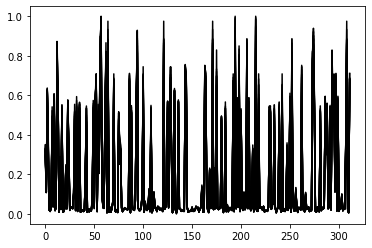

In [54]:
plt.plot(x_test, color = 'black', label = 'Tesla Stock Price')
plt.plot(prediction_x, color = 'red', label = 'Predicted Tesla Stock Price')
plt.title('Tesla Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Tesla Stock Price')
plt.legend()
plt.show()